<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:19:38] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


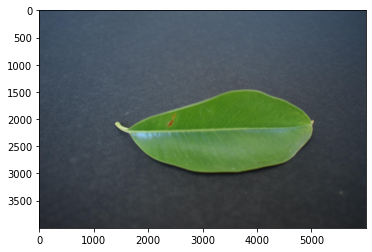

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

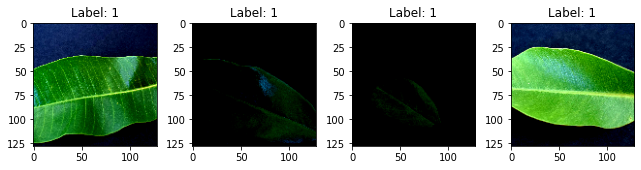

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:19:44] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:19:46] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2436820401786337 samples/sec                   batch loss = 1.0609664916992188 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.264637689396409 samples/sec                   batch loss = 1.7089182138442993 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2609931299796073 samples/sec                   batch loss = 0.7719189524650574 | accuracy = 0.6


Epoch[1] Batch[20] Speed: 1.2581679938991974 samples/sec                   batch loss = 1.2691320180892944 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2570227383547263 samples/sec                   batch loss = 0.3803943693637848 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2531770471295167 samples/sec                   batch loss = 0.47261711955070496 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2582943457358644 samples/sec                   batch loss = 0.6328909993171692 | accuracy = 0.5785714285714286


Epoch[1] Batch[40] Speed: 1.2566883882124642 samples/sec                   batch loss = 0.6815702319145203 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.257269165895044 samples/sec                   batch loss = 0.5826694369316101 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.257902822503552 samples/sec                   batch loss = 0.7262377142906189 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2531683418063213 samples/sec                   batch loss = 0.7982590198516846 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.2521363550501599 samples/sec                   batch loss = 0.664767861366272 | accuracy = 0.6041666666666666


Epoch[1] Batch[65] Speed: 1.2582166821170016 samples/sec                   batch loss = 0.49713051319122314 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.2639315260332113 samples/sec                   batch loss = 0.492253839969635 | accuracy = 0.6107142857142858


Epoch[1] Batch[75] Speed: 1.267831728846953 samples/sec                   batch loss = 0.4887408912181854 | accuracy = 0.6166666666666667


Epoch[1] Batch[80] Speed: 1.2648852046826613 samples/sec                   batch loss = 0.37218382954597473 | accuracy = 0.615625


Epoch[1] Batch[85] Speed: 1.2697566582087951 samples/sec                   batch loss = 0.34806013107299805 | accuracy = 0.6147058823529412


Epoch[1] Batch[90] Speed: 1.2627640681749843 samples/sec                   batch loss = 0.7341646552085876 | accuracy = 0.6027777777777777


Epoch[1] Batch[95] Speed: 1.2603399771583692 samples/sec                   batch loss = 0.5671328902244568 | accuracy = 0.6


Epoch[1] Batch[100] Speed: 1.2711199462798306 samples/sec                   batch loss = 0.2316579967737198 | accuracy = 0.6075


Epoch[1] Batch[105] Speed: 1.2673008855506898 samples/sec                   batch loss = 2.1039695739746094 | accuracy = 0.611904761904762


Epoch[1] Batch[110] Speed: 1.2613227577150994 samples/sec                   batch loss = 0.3856604993343353 | accuracy = 0.6113636363636363


Epoch[1] Batch[115] Speed: 1.2555062673853425 samples/sec                   batch loss = 0.9495090842247009 | accuracy = 0.6130434782608696


Epoch[1] Batch[120] Speed: 1.2646599007944106 samples/sec                   batch loss = 0.35454487800598145 | accuracy = 0.6145833333333334


Epoch[1] Batch[125] Speed: 1.263630988650289 samples/sec                   batch loss = 1.4841740131378174 | accuracy = 0.614


Epoch[1] Batch[130] Speed: 1.2640676097563033 samples/sec                   batch loss = 0.4223657250404358 | accuracy = 0.6192307692307693


Epoch[1] Batch[135] Speed: 1.2619124786922913 samples/sec                   batch loss = 0.840634822845459 | accuracy = 0.6240740740740741


Epoch[1] Batch[140] Speed: 1.2615761866931257 samples/sec                   batch loss = 0.702812671661377 | accuracy = 0.6178571428571429


Epoch[1] Batch[145] Speed: 1.2649498644627855 samples/sec                   batch loss = 0.30004969239234924 | accuracy = 0.6206896551724138


Epoch[1] Batch[150] Speed: 1.260178474788305 samples/sec                   batch loss = 1.0078413486480713 | accuracy = 0.6216666666666667


Epoch[1] Batch[155] Speed: 1.2529406422812024 samples/sec                   batch loss = 0.6720242500305176 | accuracy = 0.6241935483870967


Epoch[1] Batch[160] Speed: 1.2575657417627206 samples/sec                   batch loss = 0.5064855813980103 | accuracy = 0.63125


Epoch[1] Batch[165] Speed: 1.2544601101849977 samples/sec                   batch loss = 0.730130136013031 | accuracy = 0.6333333333333333


Epoch[1] Batch[170] Speed: 1.253056961785653 samples/sec                   batch loss = 0.6293467283248901 | accuracy = 0.6323529411764706


Epoch[1] Batch[175] Speed: 1.2587330467677416 samples/sec                   batch loss = 0.41531988978385925 | accuracy = 0.6371428571428571


Epoch[1] Batch[180] Speed: 1.266182715428476 samples/sec                   batch loss = 0.23624427616596222 | accuracy = 0.6402777777777777


Epoch[1] Batch[185] Speed: 1.2571278538840158 samples/sec                   batch loss = 0.2773120105266571 | accuracy = 0.6405405405405405


Epoch[1] Batch[190] Speed: 1.2580910062686275 samples/sec                   batch loss = 0.4251227378845215 | accuracy = 0.6421052631578947


Epoch[1] Batch[195] Speed: 1.2623751730410637 samples/sec                   batch loss = 1.2701042890548706 | accuracy = 0.6410256410256411


Epoch[1] Batch[200] Speed: 1.2683692498392163 samples/sec                   batch loss = 0.4600214660167694 | accuracy = 0.64125


Epoch[1] Batch[205] Speed: 1.2599474639387207 samples/sec                   batch loss = 0.9456627368927002 | accuracy = 0.6414634146341464


Epoch[1] Batch[210] Speed: 1.2598738535348104 samples/sec                   batch loss = 0.3825124502182007 | accuracy = 0.6416666666666667


Epoch[1] Batch[215] Speed: 1.2589316814929596 samples/sec                   batch loss = 0.49616944789886475 | accuracy = 0.6453488372093024


Epoch[1] Batch[220] Speed: 1.2607843695712178 samples/sec                   batch loss = 0.4114561378955841 | accuracy = 0.6454545454545455


Epoch[1] Batch[225] Speed: 1.264670101139892 samples/sec                   batch loss = 1.0701407194137573 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.2591958692722787 samples/sec                   batch loss = 0.47209858894348145 | accuracy = 0.6434782608695652


Epoch[1] Batch[235] Speed: 1.2628052235521094 samples/sec                   batch loss = 1.0222352743148804 | accuracy = 0.6404255319148936


Epoch[1] Batch[240] Speed: 1.2614382677262803 samples/sec                   batch loss = 0.9335288405418396 | accuracy = 0.6416666666666667


Epoch[1] Batch[245] Speed: 1.2597364956814954 samples/sec                   batch loss = 0.2711672782897949 | accuracy = 0.639795918367347


Epoch[1] Batch[250] Speed: 1.2698140321991387 samples/sec                   batch loss = 0.39706334471702576 | accuracy = 0.641


Epoch[1] Batch[255] Speed: 1.2448188061453205 samples/sec                   batch loss = 0.2842038571834564 | accuracy = 0.6401960784313725


Epoch[1] Batch[260] Speed: 1.2670166367707858 samples/sec                   batch loss = 0.41879090666770935 | accuracy = 0.6432692307692308


Epoch[1] Batch[265] Speed: 1.264143425574354 samples/sec                   batch loss = 0.9776159524917603 | accuracy = 0.6433962264150943


Epoch[1] Batch[270] Speed: 1.2651854803491556 samples/sec                   batch loss = 0.43836480379104614 | accuracy = 0.6425925925925926


Epoch[1] Batch[275] Speed: 1.268983336346219 samples/sec                   batch loss = 0.7840431332588196 | accuracy = 0.6418181818181818


Epoch[1] Batch[280] Speed: 1.26270200751756 samples/sec                   batch loss = 0.3302558958530426 | accuracy = 0.6419642857142858


Epoch[1] Batch[285] Speed: 1.2679572502044145 samples/sec                   batch loss = 0.5355307459831238 | accuracy = 0.6421052631578947


Epoch[1] Batch[290] Speed: 1.2709051239913831 samples/sec                   batch loss = 0.6213106513023376 | accuracy = 0.6422413793103449


Epoch[1] Batch[295] Speed: 1.2625416094553117 samples/sec                   batch loss = 0.5698121786117554 | accuracy = 0.6457627118644068


Epoch[1] Batch[300] Speed: 1.2654112578894854 samples/sec                   batch loss = 0.8057670593261719 | accuracy = 0.645


Epoch[1] Batch[305] Speed: 1.2715297639253529 samples/sec                   batch loss = 0.3234289884567261 | accuracy = 0.6467213114754098


Epoch[1] Batch[310] Speed: 1.2552264391262293 samples/sec                   batch loss = 0.24218079447746277 | accuracy = 0.646774193548387


Epoch[1] Batch[315] Speed: 1.262183046760959 samples/sec                   batch loss = 0.72662752866745 | accuracy = 0.65


Epoch[1] Batch[320] Speed: 1.2634979486967846 samples/sec                   batch loss = 0.6428058743476868 | accuracy = 0.653125


Epoch[1] Batch[325] Speed: 1.251243228424014 samples/sec                   batch loss = 0.5400834083557129 | accuracy = 0.6523076923076923


Epoch[1] Batch[330] Speed: 1.2510659500950647 samples/sec                   batch loss = 0.6126944422721863 | accuracy = 0.6553030303030303


Epoch[1] Batch[335] Speed: 1.2584560262780418 samples/sec                   batch loss = 0.5197852849960327 | accuracy = 0.6567164179104478


Epoch[1] Batch[340] Speed: 1.2530430172785814 samples/sec                   batch loss = 0.5683140754699707 | accuracy = 0.6588235294117647


Epoch[1] Batch[345] Speed: 1.2491145487398192 samples/sec                   batch loss = 0.791331946849823 | accuracy = 0.6594202898550725


Epoch[1] Batch[350] Speed: 1.2526520423520406 samples/sec                   batch loss = 0.9783159494400024 | accuracy = 0.6614285714285715


Epoch[1] Batch[355] Speed: 1.258630778584062 samples/sec                   batch loss = 0.1433231085538864 | accuracy = 0.6626760563380282


Epoch[1] Batch[360] Speed: 1.256217906561563 samples/sec                   batch loss = 0.4714500606060028 | accuracy = 0.6631944444444444


Epoch[1] Batch[365] Speed: 1.2593417113720837 samples/sec                   batch loss = 0.6504623293876648 | accuracy = 0.663013698630137


Epoch[1] Batch[370] Speed: 1.2578783014475499 samples/sec                   batch loss = 0.2590937614440918 | accuracy = 0.6662162162162162


Epoch[1] Batch[375] Speed: 1.2693596031980157 samples/sec                   batch loss = 0.36393803358078003 | accuracy = 0.67


Epoch[1] Batch[380] Speed: 1.2623418340355992 samples/sec                   batch loss = 0.5351530909538269 | accuracy = 0.6723684210526316


Epoch[1] Batch[385] Speed: 1.2623538966633263 samples/sec                   batch loss = 0.6019867062568665 | accuracy = 0.6701298701298701


Epoch[1] Batch[390] Speed: 1.2665052145568998 samples/sec                   batch loss = 0.617882251739502 | accuracy = 0.6711538461538461


Epoch[1] Batch[395] Speed: 1.2657703203805486 samples/sec                   batch loss = 1.2846423387527466 | accuracy = 0.6683544303797468


Epoch[1] Batch[400] Speed: 1.2683417301207363 samples/sec                   batch loss = 0.1677069067955017 | accuracy = 0.67125


Epoch[1] Batch[405] Speed: 1.2676653315940718 samples/sec                   batch loss = 0.509941816329956 | accuracy = 0.6709876543209876


Epoch[1] Batch[410] Speed: 1.259790318984834 samples/sec                   batch loss = 0.7787346243858337 | accuracy = 0.6689024390243903


Epoch[1] Batch[415] Speed: 1.26090603541359 samples/sec                   batch loss = 1.575503945350647 | accuracy = 0.6680722891566265


Epoch[1] Batch[420] Speed: 1.2552373330923197 samples/sec                   batch loss = 0.4140731990337372 | accuracy = 0.669047619047619


Epoch[1] Batch[425] Speed: 1.246234380858942 samples/sec                   batch loss = 0.7506072521209717 | accuracy = 0.6711764705882353


Epoch[1] Batch[430] Speed: 1.2596414411518067 samples/sec                   batch loss = 0.46944460272789 | accuracy = 0.6738372093023256


Epoch[1] Batch[435] Speed: 1.269313698023741 samples/sec                   batch loss = 0.7964529991149902 | accuracy = 0.6752873563218391


Epoch[1] Batch[440] Speed: 1.2585374957879256 samples/sec                   batch loss = 1.0727794170379639 | accuracy = 0.6738636363636363


Epoch[1] Batch[445] Speed: 1.2686762667505533 samples/sec                   batch loss = 0.30390462279319763 | accuracy = 0.6741573033707865


Epoch[1] Batch[450] Speed: 1.2675706090901708 samples/sec                   batch loss = 0.283573180437088 | accuracy = 0.675


Epoch[1] Batch[455] Speed: 1.2679054097457496 samples/sec                   batch loss = 0.48885709047317505 | accuracy = 0.6763736263736264


Epoch[1] Batch[460] Speed: 1.2740051618680288 samples/sec                   batch loss = 0.23708969354629517 | accuracy = 0.6777173913043478


Epoch[1] Batch[465] Speed: 1.2632165444677068 samples/sec                   batch loss = 0.7096997499465942 | accuracy = 0.6774193548387096


Epoch[1] Batch[470] Speed: 1.2709540327669655 samples/sec                   batch loss = 0.3311081826686859 | accuracy = 0.6781914893617021


Epoch[1] Batch[475] Speed: 1.2714336922180347 samples/sec                   batch loss = 0.8059910535812378 | accuracy = 0.6784210526315789


Epoch[1] Batch[480] Speed: 1.274013772111281 samples/sec                   batch loss = 0.7480254769325256 | accuracy = 0.678125


Epoch[1] Batch[485] Speed: 1.2673749834564256 samples/sec                   batch loss = 1.8417553901672363 | accuracy = 0.6783505154639176


Epoch[1] Batch[490] Speed: 1.2589459463130288 samples/sec                   batch loss = 1.2357239723205566 | accuracy = 0.6775510204081633


Epoch[1] Batch[495] Speed: 1.2709037761650395 samples/sec                   batch loss = 0.38711991906166077 | accuracy = 0.6792929292929293


Epoch[1] Batch[500] Speed: 1.2641189463575768 samples/sec                   batch loss = 0.7325060963630676 | accuracy = 0.679


Epoch[1] Batch[505] Speed: 1.2640891344284262 samples/sec                   batch loss = 0.0607849583029747 | accuracy = 0.6801980198019802


Epoch[1] Batch[510] Speed: 1.2674848059788069 samples/sec                   batch loss = 0.363254576921463 | accuracy = 0.6813725490196079


Epoch[1] Batch[515] Speed: 1.2562911844343805 samples/sec                   batch loss = 0.6068993806838989 | accuracy = 0.6815533980582524


Epoch[1] Batch[520] Speed: 1.261079667834524 samples/sec                   batch loss = 0.8547135591506958 | accuracy = 0.6817307692307693


Epoch[1] Batch[525] Speed: 1.2616060699487905 samples/sec                   batch loss = 0.38117191195487976 | accuracy = 0.6847619047619048


Epoch[1] Batch[530] Speed: 1.2565683819199687 samples/sec                   batch loss = 0.16937214136123657 | accuracy = 0.6849056603773584


Epoch[1] Batch[535] Speed: 1.2584220444320697 samples/sec                   batch loss = 0.23884505033493042 | accuracy = 0.6855140186915888


Epoch[1] Batch[540] Speed: 1.2658692630497843 samples/sec                   batch loss = 0.20894332230091095 | accuracy = 0.6856481481481481


Epoch[1] Batch[545] Speed: 1.266273598825959 samples/sec                   batch loss = 0.5473619699478149 | accuracy = 0.6857798165137615


Epoch[1] Batch[550] Speed: 1.2615428898757994 samples/sec                   batch loss = 0.8034576177597046 | accuracy = 0.6859090909090909


Epoch[1] Batch[555] Speed: 1.2642719332003995 samples/sec                   batch loss = 0.33296310901641846 | accuracy = 0.6864864864864865


Epoch[1] Batch[560] Speed: 1.2629075058059727 samples/sec                   batch loss = 0.22296392917633057 | accuracy = 0.6870535714285714


Epoch[1] Batch[565] Speed: 1.2666500771893883 samples/sec                   batch loss = 0.3275875449180603 | accuracy = 0.6884955752212389


Epoch[1] Batch[570] Speed: 1.2689063630709059 samples/sec                   batch loss = 0.3047577142715454 | accuracy = 0.6885964912280702


Epoch[1] Batch[575] Speed: 1.2735311009491734 samples/sec                   batch loss = 0.3506271541118622 | accuracy = 0.6895652173913044


Epoch[1] Batch[580] Speed: 1.2594266991119194 samples/sec                   batch loss = 1.0778862237930298 | accuracy = 0.6896551724137931


Epoch[1] Batch[585] Speed: 1.26296920636615 samples/sec                   batch loss = 0.5359381437301636 | accuracy = 0.6893162393162393


Epoch[1] Batch[590] Speed: 1.2730206858455761 samples/sec                   batch loss = 1.3563873767852783 | accuracy = 0.6898305084745763


Epoch[1] Batch[595] Speed: 1.2657559959863294 samples/sec                   batch loss = 0.8204580545425415 | accuracy = 0.6890756302521008


Epoch[1] Batch[600] Speed: 1.2620074965755408 samples/sec                   batch loss = 0.5223509669303894 | accuracy = 0.6904166666666667


Epoch[1] Batch[605] Speed: 1.2642523076621657 samples/sec                   batch loss = 0.97044837474823 | accuracy = 0.6904958677685951


Epoch[1] Batch[610] Speed: 1.2512067423043982 samples/sec                   batch loss = 0.5633666515350342 | accuracy = 0.6901639344262295


Epoch[1] Batch[615] Speed: 1.2496699147089105 samples/sec                   batch loss = 0.5558423399925232 | accuracy = 0.6910569105691057


Epoch[1] Batch[620] Speed: 1.2656407441603204 samples/sec                   batch loss = 1.042460560798645 | accuracy = 0.6911290322580645


Epoch[1] Batch[625] Speed: 1.2669472688036016 samples/sec                   batch loss = 0.20359741151332855 | accuracy = 0.6904


Epoch[1] Batch[630] Speed: 1.2643089947377029 samples/sec                   batch loss = 0.6074649095535278 | accuracy = 0.6908730158730159


Epoch[1] Batch[635] Speed: 1.2701153066947926 samples/sec                   batch loss = 0.9555509090423584 | accuracy = 0.6921259842519685


Epoch[1] Batch[640] Speed: 1.264105040298716 samples/sec                   batch loss = 0.19983163475990295 | accuracy = 0.694140625


Epoch[1] Batch[645] Speed: 1.2713076743196732 samples/sec                   batch loss = 0.3306805193424225 | accuracy = 0.6937984496124031


Epoch[1] Batch[650] Speed: 1.2653951282499956 samples/sec                   batch loss = 0.3134187161922455 | accuracy = 0.6942307692307692


Epoch[1] Batch[655] Speed: 1.2659709914748587 samples/sec                   batch loss = 0.5521153211593628 | accuracy = 0.6950381679389313


Epoch[1] Batch[660] Speed: 1.2621017692141556 samples/sec                   batch loss = 1.0955806970596313 | accuracy = 0.6950757575757576


Epoch[1] Batch[665] Speed: 1.266399098609002 samples/sec                   batch loss = 0.7518517374992371 | accuracy = 0.6954887218045113


Epoch[1] Batch[670] Speed: 1.2623401243904793 samples/sec                   batch loss = 0.35828897356987 | accuracy = 0.6955223880597015


Epoch[1] Batch[675] Speed: 1.267639853775617 samples/sec                   batch loss = 0.7218711972236633 | accuracy = 0.6966666666666667


Epoch[1] Batch[680] Speed: 1.257741849803552 samples/sec                   batch loss = 0.666408121585846 | accuracy = 0.6977941176470588


Epoch[1] Batch[685] Speed: 1.2605333421690497 samples/sec                   batch loss = 0.2675706148147583 | accuracy = 0.6981751824817518


Epoch[1] Batch[690] Speed: 1.2586142548138544 samples/sec                   batch loss = 0.2005710005760193 | accuracy = 0.6996376811594203


Epoch[1] Batch[695] Speed: 1.2556406367887867 samples/sec                   batch loss = 0.35683244466781616 | accuracy = 0.7007194244604317


Epoch[1] Batch[700] Speed: 1.2558754294208518 samples/sec                   batch loss = 0.636290431022644 | accuracy = 0.7017857142857142


Epoch[1] Batch[705] Speed: 1.2509251895674913 samples/sec                   batch loss = 0.3802469074726105 | accuracy = 0.701063829787234


Epoch[1] Batch[710] Speed: 1.2480633210837189 samples/sec                   batch loss = 0.8100132346153259 | accuracy = 0.701056338028169


Epoch[1] Batch[715] Speed: 1.2572386398107505 samples/sec                   batch loss = 0.34044143557548523 | accuracy = 0.7006993006993008


Epoch[1] Batch[720] Speed: 1.2520243174812793 samples/sec                   batch loss = 0.9133276343345642 | accuracy = 0.6986111111111111


Epoch[1] Batch[725] Speed: 1.2528452071689573 samples/sec                   batch loss = 0.5619995594024658 | accuracy = 0.6996551724137932


Epoch[1] Batch[730] Speed: 1.2562169659512454 samples/sec                   batch loss = 0.5937017202377319 | accuracy = 0.6996575342465754


Epoch[1] Batch[735] Speed: 1.2607266717845533 samples/sec                   batch loss = 0.46857985854148865 | accuracy = 0.7


Epoch[1] Batch[740] Speed: 1.2521815869057094 samples/sec                   batch loss = 0.32132619619369507 | accuracy = 0.7003378378378379


Epoch[1] Batch[745] Speed: 1.2601088124538036 samples/sec                   batch loss = 0.9500971436500549 | accuracy = 0.7


Epoch[1] Batch[750] Speed: 1.226911586570709 samples/sec                   batch loss = 0.820612907409668 | accuracy = 0.7003333333333334


Epoch[1] Batch[755] Speed: 1.2638047060055375 samples/sec                   batch loss = 0.7626824378967285 | accuracy = 0.7


Epoch[1] Batch[760] Speed: 1.2615436487580456 samples/sec                   batch loss = 0.34655410051345825 | accuracy = 0.7016447368421053


Epoch[1] Batch[765] Speed: 1.266375392250897 samples/sec                   batch loss = 0.3765483498573303 | accuracy = 0.7022875816993464


Epoch[1] Batch[770] Speed: 1.2642404945251489 samples/sec                   batch loss = 0.39662298560142517 | accuracy = 0.702922077922078


Epoch[1] Batch[775] Speed: 1.264667527205417 samples/sec                   batch loss = 0.35985246300697327 | accuracy = 0.7035483870967741


Epoch[1] Batch[780] Speed: 1.2687992686631413 samples/sec                   batch loss = 0.896315336227417 | accuracy = 0.7035256410256411


Epoch[1] Batch[785] Speed: 1.252824718584781 samples/sec                   batch loss = 0.47359761595726013 | accuracy = 0.7028662420382166


[Epoch 1] training: accuracy=0.7036802030456852
[Epoch 1] time cost: 651.793205499649
[Epoch 1] validation: validation accuracy=0.7788888888888889


Epoch[2] Batch[5] Speed: 1.2701130951614894 samples/sec                   batch loss = 0.29250025749206543 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2727165833890208 samples/sec                   batch loss = 0.7103649377822876 | accuracy = 0.775


Epoch[2] Batch[15] Speed: 1.264762197689202 samples/sec                   batch loss = 0.5774821639060974 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.26177657388563 samples/sec                   batch loss = 0.4389996826648712 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2671617121334477 samples/sec                   batch loss = 0.8973106145858765 | accuracy = 0.7


Epoch[2] Batch[30] Speed: 1.26121513811545 samples/sec                   batch loss = 0.30232617259025574 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2598350648802574 samples/sec                   batch loss = 0.16685833036899567 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2633353506378757 samples/sec                   batch loss = 0.4782848358154297 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.2667979381745327 samples/sec                   batch loss = 0.4290578365325928 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2638795381689796 samples/sec                   batch loss = 0.4924805164337158 | accuracy = 0.725


Epoch[2] Batch[55] Speed: 1.2660430231755258 samples/sec                   batch loss = 0.4474572539329529 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.270126941409875 samples/sec                   batch loss = 0.23889286816120148 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2650027988495762 samples/sec                   batch loss = 0.4988110065460205 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2706036671859486 samples/sec                   batch loss = 0.40996113419532776 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.2654327328997563 samples/sec                   batch loss = 0.6821223497390747 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2742965236237802 samples/sec                   batch loss = 0.19460245966911316 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2688287274190608 samples/sec                   batch loss = 0.2899474799633026 | accuracy = 0.7617647058823529


Epoch[2] Batch[90] Speed: 1.2693302158211874 samples/sec                   batch loss = 0.29084160923957825 | accuracy = 0.7611111111111111


Epoch[2] Batch[95] Speed: 1.266188449011194 samples/sec                   batch loss = 0.5379515290260315 | accuracy = 0.7605263157894737


Epoch[2] Batch[100] Speed: 1.2655549157165007 samples/sec                   batch loss = 1.2031617164611816 | accuracy = 0.75


Epoch[2] Batch[105] Speed: 1.2578976352773625 samples/sec                   batch loss = 0.6259406208992004 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2600074561560302 samples/sec                   batch loss = 0.3837452828884125 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.256944384092445 samples/sec                   batch loss = 0.8139664530754089 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2549851299229873 samples/sec                   batch loss = 0.445788711309433 | accuracy = 0.7479166666666667


Epoch[2] Batch[125] Speed: 1.2694391288053648 samples/sec                   batch loss = 0.7295740842819214 | accuracy = 0.75


Epoch[2] Batch[130] Speed: 1.2707104889638885 samples/sec                   batch loss = 0.3810112178325653 | accuracy = 0.7538461538461538


Epoch[2] Batch[135] Speed: 1.2612848280071542 samples/sec                   batch loss = 1.0701557397842407 | accuracy = 0.7518518518518519


Epoch[2] Batch[140] Speed: 1.268937842284334 samples/sec                   batch loss = 0.48396986722946167 | accuracy = 0.7482142857142857


Epoch[2] Batch[145] Speed: 1.270779692115791 samples/sec                   batch loss = 0.47532567381858826 | accuracy = 0.7517241379310344


Epoch[2] Batch[150] Speed: 1.2692437902458846 samples/sec                   batch loss = 0.8528080582618713 | accuracy = 0.7516666666666667


Epoch[2] Batch[155] Speed: 1.2687418903882224 samples/sec                   batch loss = 0.6617175936698914 | accuracy = 0.7435483870967742


Epoch[2] Batch[160] Speed: 1.2710932700883488 samples/sec                   batch loss = 0.4080575406551361 | accuracy = 0.746875


Epoch[2] Batch[165] Speed: 1.2749691673001406 samples/sec                   batch loss = 0.8478851914405823 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.2694241449580934 samples/sec                   batch loss = 0.26928240060806274 | accuracy = 0.75


Epoch[2] Batch[175] Speed: 1.2736674225925058 samples/sec                   batch loss = 0.2406550645828247 | accuracy = 0.75


Epoch[2] Batch[180] Speed: 1.2694178057445769 samples/sec                   batch loss = 0.3484309911727905 | accuracy = 0.7458333333333333


Epoch[2] Batch[185] Speed: 1.268094393926407 samples/sec                   batch loss = 0.29554399847984314 | accuracy = 0.7472972972972973


Epoch[2] Batch[190] Speed: 1.276932855446775 samples/sec                   batch loss = 0.700448751449585 | accuracy = 0.7473684210526316


Epoch[2] Batch[195] Speed: 1.2638111796847888 samples/sec                   batch loss = 0.9663674235343933 | accuracy = 0.7423076923076923


Epoch[2] Batch[200] Speed: 1.2600225970506072 samples/sec                   batch loss = 0.6307010054588318 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.258168276959341 samples/sec                   batch loss = 0.24066120386123657 | accuracy = 0.7390243902439024


Epoch[2] Batch[210] Speed: 1.257248438145402 samples/sec                   batch loss = 0.5493918061256409 | accuracy = 0.7404761904761905


Epoch[2] Batch[215] Speed: 1.258954826562952 samples/sec                   batch loss = 0.2577151656150818 | accuracy = 0.7441860465116279


Epoch[2] Batch[220] Speed: 1.267997786455204 samples/sec                   batch loss = 0.16129769384860992 | accuracy = 0.7465909090909091


Epoch[2] Batch[225] Speed: 1.2643760730704552 samples/sec                   batch loss = 0.35356539487838745 | accuracy = 0.7477777777777778


Epoch[2] Batch[230] Speed: 1.264038371663483 samples/sec                   batch loss = 0.34129175543785095 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.2760608902222228 samples/sec                   batch loss = 0.24448785185813904 | accuracy = 0.7468085106382979


Epoch[2] Batch[240] Speed: 1.272585291585306 samples/sec                   batch loss = 0.18081161379814148 | accuracy = 0.7479166666666667


Epoch[2] Batch[245] Speed: 1.269438744599734 samples/sec                   batch loss = 0.44152694940567017 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2636048162027345 samples/sec                   batch loss = 0.5497351884841919 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.270184348868368 samples/sec                   batch loss = 0.3879944682121277 | accuracy = 0.7470588235294118


Epoch[2] Batch[260] Speed: 1.267682477018309 samples/sec                   batch loss = 0.9256736040115356 | accuracy = 0.7461538461538462


Epoch[2] Batch[265] Speed: 1.2664636264583544 samples/sec                   batch loss = 0.3787955045700073 | accuracy = 0.7452830188679245


Epoch[2] Batch[270] Speed: 1.2671688902071243 samples/sec                   batch loss = 0.5214228630065918 | accuracy = 0.7444444444444445


Epoch[2] Batch[275] Speed: 1.2619283298322426 samples/sec                   batch loss = 0.3918549418449402 | accuracy = 0.7436363636363637


Epoch[2] Batch[280] Speed: 1.2644357254076184 samples/sec                   batch loss = 0.4255288243293762 | accuracy = 0.7446428571428572


Epoch[2] Batch[285] Speed: 1.264985344318968 samples/sec                   batch loss = 0.7163835167884827 | accuracy = 0.7464912280701754


Epoch[2] Batch[290] Speed: 1.2640821816886978 samples/sec                   batch loss = 0.3571086525917053 | accuracy = 0.7456896551724138


Epoch[2] Batch[295] Speed: 1.2556374416579918 samples/sec                   batch loss = 0.1427626609802246 | accuracy = 0.7466101694915255


Epoch[2] Batch[300] Speed: 1.2687742249985612 samples/sec                   batch loss = 0.696282148361206 | accuracy = 0.7441666666666666


Epoch[2] Batch[305] Speed: 1.2683629211571052 samples/sec                   batch loss = 0.3175078332424164 | accuracy = 0.7450819672131147


Epoch[2] Batch[310] Speed: 1.271253440360629 samples/sec                   batch loss = 1.1893900632858276 | accuracy = 0.742741935483871


Epoch[2] Batch[315] Speed: 1.2723992125590715 samples/sec                   batch loss = 1.7411320209503174 | accuracy = 0.7412698412698413


Epoch[2] Batch[320] Speed: 1.2753659588782063 samples/sec                   batch loss = 0.3812480568885803 | accuracy = 0.7390625


Epoch[2] Batch[325] Speed: 1.27545496558551 samples/sec                   batch loss = 0.8388259410858154 | accuracy = 0.7415384615384616


Epoch[2] Batch[330] Speed: 1.2753748783802759 samples/sec                   batch loss = 0.5411142706871033 | accuracy = 0.740909090909091


Epoch[2] Batch[335] Speed: 1.2735357412061732 samples/sec                   batch loss = 0.5774726867675781 | accuracy = 0.7425373134328358


Epoch[2] Batch[340] Speed: 1.2677040291871173 samples/sec                   batch loss = 0.8146905303001404 | accuracy = 0.7419117647058824


Epoch[2] Batch[345] Speed: 1.267861430129583 samples/sec                   batch loss = 0.6994513869285583 | accuracy = 0.7442028985507246


Epoch[2] Batch[350] Speed: 1.273068501767833 samples/sec                   batch loss = 0.6618030071258545 | accuracy = 0.745


Epoch[2] Batch[355] Speed: 1.2707947079811652 samples/sec                   batch loss = 0.2350996434688568 | accuracy = 0.7471830985915493


Epoch[2] Batch[360] Speed: 1.265855031925891 samples/sec                   batch loss = 0.8057557940483093 | accuracy = 0.7479166666666667


Epoch[2] Batch[365] Speed: 1.262983562830986 samples/sec                   batch loss = 0.5770873427391052 | accuracy = 0.7465753424657534


Epoch[2] Batch[370] Speed: 1.251408982445368 samples/sec                   batch loss = 0.4692603051662445 | accuracy = 0.7472972972972973


Epoch[2] Batch[375] Speed: 1.2652225000526007 samples/sec                   batch loss = 1.0989019870758057 | accuracy = 0.746


Epoch[2] Batch[380] Speed: 1.2690697264542072 samples/sec                   batch loss = 0.41057541966438293 | accuracy = 0.7473684210526316


Epoch[2] Batch[385] Speed: 1.2593224276529442 samples/sec                   batch loss = 0.4593540132045746 | accuracy = 0.7467532467532467


Epoch[2] Batch[390] Speed: 1.257041763339329 samples/sec                   batch loss = 0.22543862462043762 | accuracy = 0.7480769230769231


Epoch[2] Batch[395] Speed: 1.2681858395573946 samples/sec                   batch loss = 0.23699043691158295 | accuracy = 0.7468354430379747


Epoch[2] Batch[400] Speed: 1.264033514652037 samples/sec                   batch loss = 0.43340668082237244 | accuracy = 0.7475


Epoch[2] Batch[405] Speed: 1.2655226495239096 samples/sec                   batch loss = 0.07313309609889984 | accuracy = 0.7493827160493827


Epoch[2] Batch[410] Speed: 1.2644176194707406 samples/sec                   batch loss = 0.6148695349693298 | accuracy = 0.7481707317073171


Epoch[2] Batch[415] Speed: 1.272047760505992 samples/sec                   batch loss = 0.18785718083381653 | accuracy = 0.75


Epoch[2] Batch[420] Speed: 1.264520639640075 samples/sec                   batch loss = 0.21659474074840546 | accuracy = 0.7523809523809524


Epoch[2] Batch[425] Speed: 1.2671659232601447 samples/sec                   batch loss = 0.40954020619392395 | accuracy = 0.7511764705882353


Epoch[2] Batch[430] Speed: 1.2692414857249807 samples/sec                   batch loss = 0.27219510078430176 | accuracy = 0.7517441860465116


Epoch[2] Batch[435] Speed: 1.2702500324429356 samples/sec                   batch loss = 0.6657140254974365 | accuracy = 0.7528735632183908


Epoch[2] Batch[440] Speed: 1.2604835274872703 samples/sec                   batch loss = 0.739140510559082 | accuracy = 0.7528409090909091


Epoch[2] Batch[445] Speed: 1.2711790808910914 samples/sec                   batch loss = 0.3641150891780853 | accuracy = 0.7528089887640449


Epoch[2] Batch[450] Speed: 1.269690449109847 samples/sec                   batch loss = 1.1375529766082764 | accuracy = 0.7505555555555555


Epoch[2] Batch[455] Speed: 1.2577695715144537 samples/sec                   batch loss = 0.8037065267562866 | accuracy = 0.7489010989010989


Epoch[2] Batch[460] Speed: 1.2697462795482586 samples/sec                   batch loss = 0.44199123978614807 | accuracy = 0.7505434782608695


Epoch[2] Batch[465] Speed: 1.2715208017579305 samples/sec                   batch loss = 0.27748438715934753 | accuracy = 0.7516129032258064


Epoch[2] Batch[470] Speed: 1.2722472433607703 samples/sec                   batch loss = 0.49793750047683716 | accuracy = 0.752127659574468


Epoch[2] Batch[475] Speed: 1.2725248678436567 samples/sec                   batch loss = 0.5550683736801147 | accuracy = 0.7510526315789474


Epoch[2] Batch[480] Speed: 1.269401189621748 samples/sec                   batch loss = 0.5814234614372253 | accuracy = 0.7505208333333333


Epoch[2] Batch[485] Speed: 1.2713505445776654 samples/sec                   batch loss = 0.21045130491256714 | accuracy = 0.7520618556701031


Epoch[2] Batch[490] Speed: 1.2725878013216934 samples/sec                   batch loss = 0.32694658637046814 | accuracy = 0.7520408163265306


Epoch[2] Batch[495] Speed: 1.265917498433752 samples/sec                   batch loss = 0.9831693172454834 | accuracy = 0.7525252525252525


Epoch[2] Batch[500] Speed: 1.2681905368064943 samples/sec                   batch loss = 0.5517778992652893 | accuracy = 0.753


Epoch[2] Batch[505] Speed: 1.2669065126855528 samples/sec                   batch loss = 0.44287124276161194 | accuracy = 0.7524752475247525


Epoch[2] Batch[510] Speed: 1.2739354135134127 samples/sec                   batch loss = 0.36055058240890503 | accuracy = 0.7519607843137255


Epoch[2] Batch[515] Speed: 1.2699044764370164 samples/sec                   batch loss = 0.8051483035087585 | accuracy = 0.7509708737864078


Epoch[2] Batch[520] Speed: 1.2731001878324089 samples/sec                   batch loss = 0.8315297365188599 | accuracy = 0.75


Epoch[2] Batch[525] Speed: 1.2698957294070745 samples/sec                   batch loss = 0.2677847445011139 | accuracy = 0.7509523809523809


Epoch[2] Batch[530] Speed: 1.2611700097226934 samples/sec                   batch loss = 0.26972725987434387 | accuracy = 0.7504716981132076


Epoch[2] Batch[535] Speed: 1.2636182353949545 samples/sec                   batch loss = 0.265626460313797 | accuracy = 0.7504672897196262


Epoch[2] Batch[540] Speed: 1.2556147942852414 samples/sec                   batch loss = 0.09195148199796677 | accuracy = 0.7513888888888889


Epoch[2] Batch[545] Speed: 1.2595630437834604 samples/sec                   batch loss = 0.5361597537994385 | accuracy = 0.751834862385321


Epoch[2] Batch[550] Speed: 1.259314298418893 samples/sec                   batch loss = 0.44047272205352783 | accuracy = 0.7504545454545455


Epoch[2] Batch[555] Speed: 1.2651800420700694 samples/sec                   batch loss = 0.2948470413684845 | accuracy = 0.7509009009009009


Epoch[2] Batch[560] Speed: 1.2649840090195208 samples/sec                   batch loss = 0.8069618344306946 | accuracy = 0.7517857142857143


Epoch[2] Batch[565] Speed: 1.263008188255884 samples/sec                   batch loss = 0.513895571231842 | accuracy = 0.7508849557522124


Epoch[2] Batch[570] Speed: 1.259844525307478 samples/sec                   batch loss = 0.35347631573677063 | accuracy = 0.7521929824561403


Epoch[2] Batch[575] Speed: 1.2646357828750001 samples/sec                   batch loss = 0.167976975440979 | accuracy = 0.7534782608695653


Epoch[2] Batch[580] Speed: 1.2630636227453622 samples/sec                   batch loss = 0.2712463140487671 | accuracy = 0.7530172413793104


Epoch[2] Batch[585] Speed: 1.2632422252534359 samples/sec                   batch loss = 0.49514496326446533 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2633536158579448 samples/sec                   batch loss = 0.2876738905906677 | accuracy = 0.7529661016949153


Epoch[2] Batch[595] Speed: 1.2632356622866476 samples/sec                   batch loss = 0.2251400649547577 | accuracy = 0.7533613445378151


Epoch[2] Batch[600] Speed: 1.2597487923401771 samples/sec                   batch loss = 0.2083185911178589 | accuracy = 0.7529166666666667


Epoch[2] Batch[605] Speed: 1.26174895993726 samples/sec                   batch loss = 0.4170711636543274 | accuracy = 0.7528925619834711


Epoch[2] Batch[610] Speed: 1.2630296768629448 samples/sec                   batch loss = 0.48780426383018494 | accuracy = 0.7528688524590164


Epoch[2] Batch[615] Speed: 1.2570604121504634 samples/sec                   batch loss = 0.3244919776916504 | accuracy = 0.7528455284552845


Epoch[2] Batch[620] Speed: 1.2627418282794078 samples/sec                   batch loss = 0.5291174054145813 | accuracy = 0.7536290322580645


Epoch[2] Batch[625] Speed: 1.2623554163808088 samples/sec                   batch loss = 0.39171868562698364 | accuracy = 0.7536


Epoch[2] Batch[630] Speed: 1.2594792667923653 samples/sec                   batch loss = 0.23084111511707306 | accuracy = 0.7535714285714286


Epoch[2] Batch[635] Speed: 1.2561783080857998 samples/sec                   batch loss = 0.5089658498764038 | accuracy = 0.7539370078740157


Epoch[2] Batch[640] Speed: 1.2674200782833536 samples/sec                   batch loss = 0.07720823585987091 | accuracy = 0.75546875


Epoch[2] Batch[645] Speed: 1.2662329816048008 samples/sec                   batch loss = 0.4338870644569397 | accuracy = 0.7554263565891473


Epoch[2] Batch[650] Speed: 1.2623685240959777 samples/sec                   batch loss = 0.8917210698127747 | accuracy = 0.755


Epoch[2] Batch[655] Speed: 1.265240724465234 samples/sec                   batch loss = 0.41210776567459106 | accuracy = 0.7553435114503817


Epoch[2] Batch[660] Speed: 1.2675969460804128 samples/sec                   batch loss = 0.350208580493927 | accuracy = 0.7556818181818182


Epoch[2] Batch[665] Speed: 1.2720877871060319 samples/sec                   batch loss = 0.23767684400081635 | accuracy = 0.7571428571428571


Epoch[2] Batch[670] Speed: 1.2615881398255095 samples/sec                   batch loss = 2.2971341609954834 | accuracy = 0.7563432835820896


Epoch[2] Batch[675] Speed: 1.2622729769922734 samples/sec                   batch loss = 0.5979995131492615 | accuracy = 0.7566666666666667


Epoch[2] Batch[680] Speed: 1.2626818604994217 samples/sec                   batch loss = 0.5206376910209656 | accuracy = 0.7566176470588235


Epoch[2] Batch[685] Speed: 1.2680664069143006 samples/sec                   batch loss = 0.16951479017734528 | accuracy = 0.7565693430656935


Epoch[2] Batch[690] Speed: 1.2660637553033707 samples/sec                   batch loss = 0.3376534581184387 | accuracy = 0.7565217391304347


Epoch[2] Batch[695] Speed: 1.2675161189378235 samples/sec                   batch loss = 0.5998582243919373 | accuracy = 0.7557553956834533


Epoch[2] Batch[700] Speed: 1.2623654846015515 samples/sec                   batch loss = 0.40215519070625305 | accuracy = 0.7553571428571428


Epoch[2] Batch[705] Speed: 1.259990233830809 samples/sec                   batch loss = 0.21205610036849976 | accuracy = 0.7570921985815603


Epoch[2] Batch[710] Speed: 1.257520025844151 samples/sec                   batch loss = 0.4389350414276123 | accuracy = 0.7559859154929578


Epoch[2] Batch[715] Speed: 1.2636536405892043 samples/sec                   batch loss = 0.12244841456413269 | accuracy = 0.7566433566433567


Epoch[2] Batch[720] Speed: 1.2693439489684453 samples/sec                   batch loss = 3.1186113357543945 | accuracy = 0.75625


Epoch[2] Batch[725] Speed: 1.2658552229455695 samples/sec                   batch loss = 0.5090941190719604 | accuracy = 0.7572413793103449


Epoch[2] Batch[730] Speed: 1.2684660098279332 samples/sec                   batch loss = 0.13399040699005127 | accuracy = 0.7575342465753425


Epoch[2] Batch[735] Speed: 1.2711773472248542 samples/sec                   batch loss = 0.2769719362258911 | accuracy = 0.7578231292517007


Epoch[2] Batch[740] Speed: 1.2682907211179744 samples/sec                   batch loss = 0.607492983341217 | accuracy = 0.7577702702702702


Epoch[2] Batch[745] Speed: 1.2679029184441413 samples/sec                   batch loss = 0.5937188267707825 | accuracy = 0.7577181208053692


Epoch[2] Batch[750] Speed: 1.2656206942047963 samples/sec                   batch loss = 0.6478179693222046 | accuracy = 0.7573333333333333


Epoch[2] Batch[755] Speed: 1.2771017919310768 samples/sec                   batch loss = 0.41331279277801514 | accuracy = 0.7566225165562914


Epoch[2] Batch[760] Speed: 1.2603148876150434 samples/sec                   batch loss = 0.23635433614253998 | accuracy = 0.7575657894736842


Epoch[2] Batch[765] Speed: 1.2594558187956404 samples/sec                   batch loss = 0.06114356219768524 | accuracy = 0.7581699346405228


Epoch[2] Batch[770] Speed: 1.2619951557822209 samples/sec                   batch loss = 0.3077385127544403 | accuracy = 0.759090909090909


Epoch[2] Batch[775] Speed: 1.2637496824094892 samples/sec                   batch loss = 0.20439188182353973 | accuracy = 0.7593548387096775


Epoch[2] Batch[780] Speed: 1.26153729314743 samples/sec                   batch loss = 0.3639339804649353 | accuracy = 0.7596153846153846


Epoch[2] Batch[785] Speed: 1.261166786389647 samples/sec                   batch loss = 0.29932281374931335 | accuracy = 0.7589171974522293


[Epoch 2] training: accuracy=0.7592005076142132
[Epoch 2] time cost: 640.2440214157104
[Epoch 2] validation: validation accuracy=0.7555555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7533333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)